In [35]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
from math import *
from bandits import *
from scipy.special import ndtri, erfinv
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline 

#### Bandit Setting

In [151]:
#As in Paper 1

#best mean arm = best var arm
# Arms = [(1, 5), (5, 5)]
#best mean arm != best var arm
# Arms = [(1, 1), (3, 15)]
#A
Arms = [(2, 1), (3, 1.5), (4, 5), (2, 2.5), (1, 1.5)]
#B
# Arms = [(1, 1), (3, 4), (5, 15), (7, 1), (9, 15)]
K = len(Arms)
bandit = gaussian_bandit(K, Arms)

#Parameters
#Number of rounds
n = 1000
#
trials = 10

In [152]:
epsilon = 0.05 #the low probability thingy
a = sqrt(2.)*erfinv(2*epsilon - 1)

#Best arm
#calculate true VaR
true_vs = [norm.ppf(epsilon, loc = arm[0], scale = sqrt(arm[1])) for arm in Arms]
best_arm = np.argmax(true_vs)
v_best = true_vs[best_arm]
best_arm
true_vs

1

[0.35514637304852714,
 0.9854739562013299,
 0.32199547709942644,
 -0.6007419393777882,
 -1.01452604379867]

### UCB - Risk Neutral

In [153]:
#UCB

regret_trials_0 = []
cum_regret_trials_0 = []
perc_optimal_trials_0 = []
for trial in range(trials):

    #Sample means and variances
    sample_rewards = [[] for k in range(K)]
    sample_means = [0]*K
    sample_vars = [0]*K
    net_rewards = []
    net_v = 0
    #mean-variance values
    vs = [0]*K
    #UCB values
    Bs = [0]*K
    #Number of times each arm is played
    num_played = [0]*K
    #Risk-averse regret
    regret_till_now = 0
    cum_regret_till_now = 0
    regret = []
    cum_regret = []
    perc_optimal = []

    for i in range(K):
        #Pull arm
        reward = bandit.pull_arm(i)
        #Add reward to list of rewards
        sample_rewards[i].append(reward)
        net_rewards.append(reward)
        #Add reward to mean, variance is zero so no need to update
        sample_means[i] = reward
        #Update arm played count
        num_played[i] += 1  
        vs[i] = sample_means[i] + a*sqrt(sample_vars[i])
        net_v = np.mean(net_rewards) + a*sqrt(np.var(net_rewards))
        regret_till_now = v_best - net_v
        cum_regret_till_now += v_best - true_vs[i]
        regret.append(regret_till_now)
        cum_regret.append(cum_regret_till_now)
        perc_optimal.append(num_played[best_arm]/float(i+1)) 

    for t in range(K+1, n+1):
        #Calculate  UCBs
        Bs = [mean + np.sqrt(8*np.log(t)/num) for mean, num in zip(sample_means, num_played)]

        #Pull best arm
        arm_to_pull = np.argmax(Bs)
        reward = bandit.pull_arm(arm_to_pull)
        sample_rewards[arm_to_pull].append(reward)
        net_rewards.append(reward)
        num_played[arm_to_pull] += 1

        #Update means
        sample_means[arm_to_pull] = np.mean(sample_rewards[arm_to_pull])
        sample_vars[arm_to_pull] = np.var(sample_rewards[arm_to_pull])
        vs[arm_to_pull] = sample_means[arm_to_pull] + a*sample_vars[arm_to_pull]   
        net_v = np.mean(net_rewards) + a*np.var(net_rewards)

        #Update regret
        regret_till_now = v_best - net_v
        cum_regret_till_now += v_best - true_vs[arm_to_pull]
        regret.append(regret_till_now)
        cum_regret.append(cum_regret_till_now)
        perc_optimal.append(num_played[best_arm]/float(t)) 

    regret_trials_0.append(regret)
    cum_regret_trials_0.append(cum_regret)
    perc_optimal_trials_0.append(perc_optimal)

regret_avg_0 = np.mean(np.array(regret_trials_0), axis = 0)
cum_regret_avg_0 = np.mean(np.array(cum_regret_trials_0), axis = 0)
perc_optimal_avg_0 = np.mean(np.array(perc_optimal_trials_0), axis = 0)
print("Regret", regret_avg_0[-1])
print("Cumulative Regret", cum_regret_avg_0[-1])
print("Perc optimal", perc_optimal_avg_0[-1])
print(num_played)  #of the last trial
print(vs)

('Regret', 5.419886765386744)
('Cumulative Regret', 653.1509038770425)
('Perc optimal', 0.04109999999999999)
[13, 31, 937, 10, 9]
[0.9674670045238107, 1.2285092369367452, -4.802935239670433, -5.797228929691175, -1.5795179512760549]


### VaR - UCB (Paper 6)

In [158]:
#b - refer paper
b = 0.1

regret_trials_1 = []
perc_optimal_trials_1 = []
cum_regret_trials_1 = []
for trial in range(trials):
    
    #All arms in the set initially
    S = set(range(K))

    #Sample means and variances
    sample_rewards = [[] for k in range(K)]
    sample_means = [0]*K
    sample_vars = [0]*K
    net_rewards = []
    net_v = 0
    #var values
    vs = [0]*K
    #Number of times each arm is played
    num_played = [0]*K
    #Risk-averse regret
    regret_till_now = 0
    cum_regret_till_now = 0
    regret = []
    cum_regret = []
    perc_optimal = []
    #Whether time horizon has been reached
    done = False
    #Delta - refer paper
    Delta = 1.0
    #rounds count
    rounds = 0

    for m in range(n):
        #(1)
        #Calculate n_m
        n_m = ceil(64 * b**2 * np.log(n) / (Delta**2))

        if len(S) == 1:
            i = list(S)[0]
            #print(num_played, n)
            while(sum(num_played) < n):
                #Pull arm
                reward = bandit.pull_arm(i)
                sample_rewards[i].append(reward)
                net_rewards.append(reward)
                sample_means[i] = np.mean(sample_rewards[i])
                sample_vars[i] = np.var(sample_rewards[i])
                num_played[i] += 1  
                rounds += 1
                vs[i] = sample_means[i] + a*sqrt(sample_vars[i])
                net_v = np.mean(net_rewards) + a*sqrt(np.var(net_rewards))
                regret_till_now = v_best - net_v
                cum_regret_till_now += v_best - true_vs[i]
                regret.append(regret_till_now)
                cum_regret.append(cum_regret_till_now)
                perc_optimal.append(num_played[best_arm]/float(rounds)) 
            done = True
        else:
            for i in S: 
                while(num_played[i] < n_m):
                    #Pull arm
                    reward = bandit.pull_arm(i)
                    #Add reward to list of rewards
                    sample_rewards[i].append(reward)
                    net_rewards.append(reward)
                    #Update means and variances and mean-variance
                    sample_means[i] = np.mean(sample_rewards[i])
                    sample_vars[i] = np.var(sample_rewards[i])
                    num_played[i] += 1  
                    rounds += 1
                    #Update V
                    vs[i] = sample_means[i] + a*sqrt(sample_vars[i])
                    net_v = np.mean(net_rewards) + a*sqrt(np.var(net_rewards))
                    #Update regret
                    regret_till_now = v_best - net_v##Check
                    cum_regret_till_now += v_best - true_vs[i]
                    regret.append(regret_till_now)
                    cum_regret.append(cum_regret_till_now)
                    perc_optimal.append(num_played[best_arm]/float(rounds)) 
                    
                    if rounds >= n:
                        done = True
                        break
                if done:
                    break                    
        if done:
            break
        #(2)
        #Remove arms
        #Find min_ucb
        max_lcb = -np.inf
        for arm in S:
            if vs[arm] - b*sqrt(log(n)/n_m) > max_lcb:
                max_lcb = vs[arm] - b*sqrt(log(n)/n_m)
        to_remove = []
        for arm in S:
            if vs[arm] + b*sqrt(log(n)/n_m) < max_lcb: 
                to_remove.append(arm)
        for arm in to_remove:
            S.remove(arm)    
        #(3)
        Delta = Delta/2 
        
    regret_trials_1.append(regret)
    perc_optimal_trials_1.append(perc_optimal)
    cum_regret_trials_1.append(cum_regret)
    
regret_avg_1 = np.mean(np.array(regret_trials_1), axis = 0)
perc_optimal_avg_1 = np.mean(np.array(perc_optimal_trials_1), axis = 0)
cum_regret_avg_1 = np.mean(np.array(cum_regret_trials_1), axis = 0)
print("Regret", regret_avg_1[-1])
print("Cumulative Regret", cum_regret_avg_1[-1])
print("Perc optimal", perc_optimal_avg_1[-1])
print(num_played)  #of the last trial
print(vs)

('Regret', 0.3092582805872256)
('Cumulative Regret', 281.986584948125)
('Perc optimal', 0.5886999999999999)
[5, 980, 5, 5, 5]
[-0.18204088893442982, 0.912880454330911, 0.5552387503497993, -0.2961815309748901, -1.111711981082014]


### VaR-ETC (New)

In [171]:
tau = 30

regret_trials_2 = []
cum_regret_trials_2 = []
perc_optimal_trials_2 = []
for trial in range(trials):
    
    #Sample means and variances
    sample_rewards = [[] for k in range(K)]
    sample_means = [0]*K
    sample_vars = [0]*K
    net_rewards = []
    net_v = 0
    #mean-variance values
    vs = [0]*K
    #Number of times each arm is played
    num_played = [0]*K
    #Risk-averse regret
    regret_till_now = 0
    cum_regret_till_now = 0
    regret = []
    cum_regret = []
    perc_optimal = []


    for i in range(K):
        for j in range(tau):
            #Pull arm
            reward = bandit.pull_arm(i)
            #Add reward to list of rewards
            sample_rewards[i].append(reward)
            net_rewards.append(reward)
            #Mean
            sample_means[i] = np.mean(sample_rewards[i])
            #Variance
            sample_vars[i] = np.var(sample_rewards[i])
            #Update arm played count
            num_played[i] += 1   
            #Update V
            vs[i] = sample_means[i] + a*sample_vars[i]   
            net_v = np.mean(net_rewards) + a*np.var(net_rewards)
            #Update regret
            regret_till_now = v_best - net_v
            cum_regret_till_now += v_best - true_vs[i]
            regret.append(regret_till_now)
            cum_regret.append(cum_regret_till_now)
            perc_optimal.append(num_played[best_arm]/float(i*tau+j+1)) 
            

    exploit_arm = np.argmax(vs)
    for i in range(tau*K+1, n+1):
        reward = bandit.pull_arm(exploit_arm)
        sample_rewards[exploit_arm].append(reward)
        net_rewards.append(reward)
        sample_means[exploit_arm] = np.mean(sample_rewards[exploit_arm])
        sample_vars[exploit_arm] = np.var(sample_rewards[exploit_arm])
        num_played[exploit_arm] += 1

        vs[exploit_arm] = sample_means[exploit_arm] + a*sample_vars[exploit_arm]
        net_v = np.mean(net_rewards) + a*np.var(net_rewards)
    
        #Update regret
        regret_till_now = v_best - net_v
        cum_regret_till_now += v_best - true_vs[exploit_arm]
        regret.append(regret_till_now)
        cum_regret.append(cum_regret_till_now)
        perc_optimal.append(num_played[best_arm]/float(i))

    regret_trials_2.append(regret)
    cum_regret_trials_2.append(cum_regret)
    perc_optimal_trials_2.append(perc_optimal) 

regret_avg_2 = np.mean(np.array(regret_trials_2), axis = 0)
cum_regret_avg_2 = np.mean(np.array(cum_regret_trials_2), axis = 0)
perc_optimal_avg_2 = np.mean(np.array(perc_optimal_trials_2), axis = 0)
print("Regret", regret_avg_2[-1])
print("Cumulative Regret", cum_regret_avg_2[-1])
print("Perc optimal", perc_optimal_avg_2[-1])
print(num_played)  #of the last trial
print(vs)

('Regret', 1.0621903010247613)
('Cumulative Regret', 253.5563478709922)
('Perc optimal', 0.71)
[30, 880, 30, 30, 30]
[-0.841465056245057, 0.5901306103851094, -5.4737110214396, -4.295066145008171, -0.9662647518404928]


Text(0.5,0,'n')

Text(0,0.5,'regret')

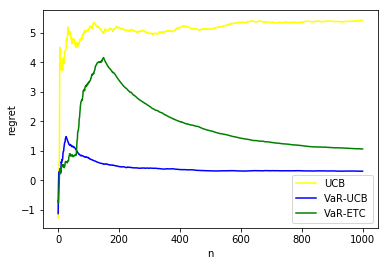

Text(0.5,0,'n')

Text(0,0.5,'perc of times optimal arm was played')

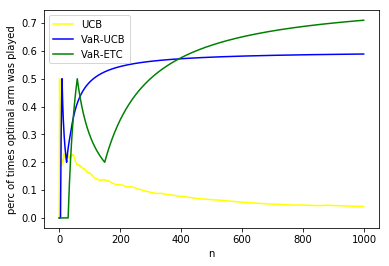

Text(0.5,0,'n')

Text(0,0.5,'cum regret')

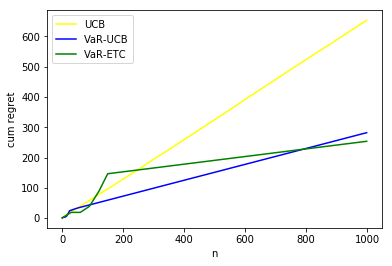

In [172]:
save = True
problem_id = "A"

#Plot regret vs rounds
plt.plot(regret_avg_0 , color = "yellow", label = "UCB")
plt.plot(regret_avg_1 , color = "blue", label = "VaR-UCB")
plt.plot(regret_avg_2 , color = "green", label = "VaR-ETC")
plt.xlabel('n')
plt.ylabel('regret')
plt.legend()
if save == True:
    plt.savefig('var_' + problem_id + '_reg.png')
plt.show()

#Plot percentage optimal vs rounds
plt.plot(perc_optimal_avg_0 , color = "yellow", label = "UCB")
plt.plot(perc_optimal_avg_1 , color = "blue", label = "VaR-UCB")
plt.plot(perc_optimal_avg_2 , color = "green", label = "VaR-ETC")
plt.xlabel('n')
plt.ylabel('perc of times optimal arm was played')
plt.legend()
if save == True:
    plt.savefig('var_' + problem_id + '_perc.png')
plt.show()

#Regret :
plt.plot(cum_regret_avg_0 , color = "yellow", label = "UCB")
plt.plot(cum_regret_avg_1, color = "blue", label = "VaR-UCB")
plt.plot(cum_regret_avg_2 , color = "green", label = "VaR-ETC")
plt.xlabel('n')
plt.ylabel('cum regret')
plt.legend()
if save == True:
    plt.savefig('var_' + problem_id + '_cumreg.png')
plt.show()